<a href="https://colab.research.google.com/github/giacomogreggio/Algoritmi_avanzati/blob/master/Alg_av_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

The following notebook contains the implementation of the HW3 of the course "Advance Algorithms 2019/2020" of the University of Padua.  
Inside this notebook we will implement and study the Karger algorithm used to solve the min cut problem.

##Cut
A cut of a multigraph is a set of edges which if removed from the multigraph causes it to be disconnected.  
A minimum cut is a cut which size is the lowest possible.


##Full Contraction
Given a multigraph $G=(V,E)$, where $V$ is the set of vertexes and $E$ is the set of edges, and an edge $e=(u,v)$ with $u≠v$, the contraction of $e$ results in a new graph $G′=(V′,E′)$, where $V′=(V\{u,v})∪{w}$ where w is a new node, $E′=E\{e}$, and for every $x∈V$, $x′=f(x)∈V′$ is incident to an edge $e′∈E′$ if and only if, the corresponding edge, $e∈E$ is incident to $x$ in $G$.

The full contraction of a graph is obtained by picking a random edge at each iteration and executing a contraction on it until the graph contains only two nodes.  
We can demonstrate that if during the full contraction we never pick an edge that is contained in a mincut, then the remaining set of edges returned at the end of the full contraction is a min cut in the original graph.

##Karger
_Karger_ is a randomized algorithm which can obtain a min cut with probability $1-\frac{1}{n^d}$ by executing a full contraction on the graph $k=d*\frac{n^2}{2}*ln(n)$ times and returning the lowest cut found.

##Important warnings

We noticed that the execution times of the algorithm implemented were too long and even with thresholds of 2/3 minutes we couldn't achieve significant results.  
The plots where uninteresting since we could measure the real execution time only for graphs of 25 and 50 nodes, even for graphs of 75 nodes the algorithm reached the time threshold before terminating.
  
So we decided to execute the python code that we produced whith another compiler called _PyPy_ which is a lot faster, but unfortunately we didn't manage to make it work properly on python notebooks.

For this reason, later on the notebook, you will find a section where we execute the algorithms produced directly on the dataset that you provided for the homework and another section where we examine the results obtained by executing the same code with the compiler _PyPy_ locally on a PC.

# Importing the dependencies


In [1]:
from pathlib import Path
from math import pi, cos, acos, sqrt, inf, log
import time
import random
import os
import matplotlib.pylab as plt
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import sys

# Notebook Configuration
In order to execute this notebook on the dataset provided you need to upload the dataset folder zipped on google colab.  
To do that click on the folder icon on the left of google colab and then on the upload button.

To execute the last section of the notebook you will need to upload also a _results.txt_ file that we attached with the submission of the homework. This file contains the results obtained by executing the algorithms implemented on this notebook with the compiler PyPy.

In [2]:
!unzip mincut_dataset.zip

Archive:  mincut_dataset.zip
replace output_random_10_25.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

We define a time threshold in order to avoid execution times too long.
  
We explicitly set this threshold to a really low time value, to avoid long execution times. For this reason the results that we will obtain by executing the algorithms directly on the dataset won't be particularly interesting.  
For this reason you will find the section which contains the results obtained with _PyPy_ which should be more interesting.  
If you desire to execute the algorithms to check its correctness you should increase the time threshold value.

In [3]:
timeout_threshold=1

# Definition of the algorithms

We start by defining a simple algorithm which given the path to a text file containing the dataset returns:
* The adiacence list.
* The number of iterations $k=\frac{n^2}{2}*ln(n)$ needed for the Karger algorithm to obtain the correct solution with probability higher than $1-\frac{1}{n}$.
* The number of nodes $n$.

In [4]:
def import_graph(dataset_path):
    dataset = open(dataset_path,"r").read().split("\n")
    adiacence_list={}
    n=0

    for node_data in dataset:
        row=node_data.split()
        #Condition needed to avoid errors obtained by reaching the EOF
        if len(row)>0:
            #Counting the number of rows and so the number of nodes
            n=n+1
            node_name=int(row[0])
            adiacence_list[node_name]=[]
            for i in range(1,len(row)):
                adiacence_list[node_name].append(int(row[i]))
                    
    k=int(((n**2)/2)*log(n))
    return adiacence_list, k, n

Then we proceed to define the _full_contraction_ algorithm which contracts the graph until we have two nodes by picking at random two nodes at each iteration.

In [5]:
def full_contraction(adiacence_list):
    while len(adiacence_list) > 2:
        #The first node is chosen at random from all nodes contained in the
        #adiacence list.
        #The second one is taken at random from the list associated to the node
        #randomly picked immediately before.
        v = random.choice(list(adiacence_list.keys()))
        w = random.choice(adiacence_list[v])

        #We remove w from the graph and v becomes the new contracted node,
        #we do this to save time since removing both nodes and creating a new one,
        #seemed like a waste of time.

        #For each node adiacent to w we make the following operations:
        for node in adiacence_list[w]:
            #If it is different from v we add it to the adiacence list of v
            #and viceversa
            if node != v:
                adiacence_list[v].append(node)
                adiacence_list[node].append(v)
            #We remove w from its adiacence list            
            adiacence_list[node].remove(w)
        #We can now proceed to delete w from the graph
        del adiacence_list[w] 
    #We can calculate the cost of the cut found by counting the number of nodes
    #in the adiacence list of one the remaining two nodes.
    cut_cost = len(adiacence_list[list(adiacence_list.keys())[0]])
    return cut_cost

    

Now we can implement the _Karger_ algorithm which runs the previously defined _full_contraction_ algorithm $k$ times and returns the best solution found.  
If $k=\frac{n^2}{2}*ln(n)$ then the algorithm has a probability of $\frac{1}{n}$ of not returning the correct solution.  
  
The _karger_ method returns:
* **discovery_time**: the time used to find the best solution.
* **avg_contraction_time**: the average time needed to complete a full contraction.
* **total_time**: The time used to complete $K$ times the full contraction.
* **min_cut**: The cost of the minimum cost cut found.

In [6]:
def karger(graph, k):
    min_cut = inf
    starting_time = time.time()
    discovery_time, contraction_time, total_time = 0, 0, 0

    for i in range(0,k):
        #If we have exceeded the time_threshold defined at the beginning, we stop
        #the algorithm and return the best solution found so far.
        if time.time()>starting_time+timeout_threshold:
            break
        #At each iteration we generate a copy of the graph since the full_contraction
        #algorithm drastically modifies the original graph.
        graph_copy=copy.deepcopy(graph)

        full_contraction_start_time=time.time()
        cut=full_contraction(graph_copy)
        contraction_time=contraction_time+(time.time()-full_contraction_start_time)
        
        if cut<min_cut:
            discovery_time=time.time()-starting_time
            min_cut=cut
    
    total_time=time.time()-starting_time
    avg_contraction_time=contraction_time/k

    return discovery_time,avg_contraction_time,total_time, min_cut


# Executing the algorithms

##Creating support functions

In this section we will define a bunch of methods that will be useful to plot the table and graphs required by the homework.  
Most of this methods take in input a data structure called _results_, this data structure for each dataset on which we executed the algorithm contains the following information:

* **Dataset Name**: The name of the dataset.
* **Number of Nodes**: The number of nodes of the graph contained in the dataset.
* **Number of Iterations(K)**: The number of iterations needed to obtain the minimum cut with probability $1-\frac{1}{n}$.
* **Solution Found**: The cost of the solution found.
* **Optimal Solution**: The cost of the optimal solution given in the corresponding output file.
* **Error(%)**: The errore percentage calculated with the following formula $\frac{Solution Found-Optimal Solution}{Optimal Solution}*100$
* **Discovery Time**: The time used to find minimum cost cut found during the execution of the algorithm
* **Asymptotic Contraction Time**: The value obtained by calculating the theoretical bound $O(n^2)$ of the full_contraction algorithm
* **Avg Contraction Time**: The average time needed to complete a full contraction.
* **Asymptotic Karger Time**: The value obtained by calculating the theoretical bound $O(n^4*log(n))$ of the _Karger_ algorithm
* **Total Time**: The total time needed to execute the karger algorithm.

The asymptotic values obtained by using the theoritical bounds are way bigger than the real execution times of the algorithms.  
To compare the two curves we need to scale down by a factor the asymptotic values contained in the results data structure. To do this we use the following method which gets in input:
* **results**: the results data structure.
* **fc_asymptotic_regularizer**: the factor by which you want to scale the full_contraction asymptotic curve.
* **k_asymptotic_regularizer**: the factor by which you want to scale the Karger asymptotic curve.

In [7]:
def asymptotic_regularizer(results, fc_asymptotic_regularizer, k_asymptotic_regularizer):
  for row in results:
    row[7]*=fc_asymptotic_regularizer
    row[9]*=k_asymptotic_regularizer
  return results

We define a function which given the results data structure creates a table which contains all the information in it

In [8]:
def plot_table(results):
  #The titles of the table columns
  header =[
          'Dataset Name',
          'Number of Nodes', 
          'Number of Iterations(K)',
          'Solution Found',
          'Optimal Solution',
          'Error(%)',
          "Discovery Time",
          "Asymptotic Contraction Time",
          "Avg Contraction Time",
          "Asymptotic Karger Time",
          "Total Time"
  ]
  #Some style properties used to make the table more readable
  table_properties = {
      'font-size': '10pt',
      'border-color': 'black',
      'border-style' :'solid' ,
      'border-width': '1px',
      'padding': '5px',
      'text-align': 'center'
  }
  header_properties = [{'selector': 'th', 
                        'props': [
                                  ('font-size', '10pt'),
                                  ('padding-top', '5px'),
                                  ('padding-bottom', '5px'),
                                  ('padding-left', '5px'),
                                  ('padding-right', '5px'),
                                  ('border-color', 'black'),
                                  ('border-style' ,'solid') ,
                                  ('border-width', '1px'),
                                  ("word-wrap","break-word")
                        ]
  }]
  #We return a panda dataframe that will be used to visualize the table
  df = pd.DataFrame(results, columns=header).style.set_properties(**table_properties).set_table_styles(header_properties).hide_index()

  return df

This function given the results data structure rearranges the data in a better way to plot the by using the matplotlib library

In [9]:
def calculate_plot_data(results):
  average_times_contraction={}
  average_times_karger={}
  asymptotic_times_contraction={}
  asymptotic_times_karger={}
  
  #We take the average of the data that we want to plot for each different
  #graph size
  for i in range(len(results)):
    if results[i][1] not in average_times_contraction:
      average_times_contraction[results[i][1]]=[]
      average_times_karger[results[i][1]]=[]
      asymptotic_times_contraction[results[i][1]]=[]
      asymptotic_times_karger[results[i][1]]=[]

    average_times_contraction[results[i][1]].append(results[i][8])
    average_times_karger[results[i][1]].append(results[i][10])
    asymptotic_times_contraction[results[i][1]].append(results[i][7])
    asymptotic_times_karger[results[i][1]].append(results[i][9])
  for i in average_times_karger.keys():
    average_times_contraction[i]=sum(average_times_contraction[i])/len(average_times_contraction[i])
    average_times_karger[i]=sum(average_times_karger[i])/len(average_times_karger[i])
    asymptotic_times_contraction[i]=sum(asymptotic_times_contraction[i])/len(asymptotic_times_contraction[i])
    asymptotic_times_karger[i]=sum(asymptotic_times_karger[i])/len(asymptotic_times_karger[i])
  
  #From the hashes created before we extract the Xs and Ys that will be used
  #in the plots
  keys=list(average_times_contraction.keys())
  keys.sort()
  average_times_contraction_values=[]
  average_times_karger_values=[]
  asymptotic_times_contraction_values=[]
  asymptotic_times_karger_values=[]

  for k in keys:
    average_times_contraction_values.append(average_times_contraction[k])
    average_times_karger_values.append(average_times_karger[k])
    asymptotic_times_contraction_values.append(asymptotic_times_contraction[k])
    asymptotic_times_karger_values.append(asymptotic_times_karger[k])

  return average_times_contraction_values, average_times_karger_values, asymptotic_times_contraction_values, asymptotic_times_karger_values, keys

Given the results data structure this function plots the relevant graph with the support of the function defined above.

In [10]:
def plot_results(results):
  average_times_contraction_values, average_times_karger_values, asymptotic_times_contraction_values, asymptotic_times_karger_values, keys=calculate_plot_data(results)
  #We plot the graphs compairing the execution times with the asymptotic values
  fig, ax = plt.subplots(nrows=1, ncols=2)
  ax1,ax2=ax

  fig.set_figwidth(24)
  fig.set_figheight(8)

  ax1.plot(keys, average_times_contraction_values,label="Avg Time for full contraction")
  ax1.scatter(keys, average_times_contraction_values)
  ax1.plot(keys, asymptotic_times_contraction_values, label="Avg asymptotic Time for Full Contraction")
  ax1.scatter(keys, asymptotic_times_contraction_values)

  ax2.plot(keys, average_times_karger_values, label="Avg Time for Karger")
  ax2.scatter(keys, average_times_karger_values)
  ax2.plot(keys, asymptotic_times_karger_values, label="Avg asymptotic Time for Karger")
  ax2.scatter(keys, asymptotic_times_karger_values)

  ax1.set_title("Average Execution Times of Full Contraction")
  ax1.set_xlabel("n_nodes")
  ax1.set_ylabel("Time in seconds")
  ax1.legend()

  ax2.set_title("Average Execution Times of Karger")
  ax2.set_xlabel("n_nodes")
  ax2.set_ylabel("Time in seconds")
  ax2.legend()

  fig.show()
  
  #We plot the graph compairing the discovery time with the total time
  fig, ax = plt.subplots(nrows=1, ncols=1)
  fig.set_figwidth(24)
  fig.set_figheight(8)

  dataset_names=[row[0] for row in results]
  discovery_times=[row[6] for row in results]
  total_times=[row[-1] for row in results]

  ax.plot(dataset_names,discovery_times,label="Discovery Times")
  ax.scatter(dataset_names,discovery_times)

  ax.plot(dataset_names,total_times,label="Total Times")
  ax.scatter(dataset_names,total_times)

  ax.set_title("Discovery Time vs Total Time")
  ax.set_xlabel("Dataset Names")
  ax.set_ylabel("Time in seconds")
  ax.set_xticklabels(dataset_names,rotation=90)
  ax.legend()

  fig.show()

##Plotting Notebook Results

In this section we will run karger on all the datasets given with the homework that should have been uploaded in a zip file.  
In order to do that we define a method called _execute_all_ which also keeps track of the results and execution times of the single executions.

In [11]:
def execute_all():
    results=[]
    #We get the paths to all the files uploaded on the notebook
    datasets=[el for el in os.listdir(Path().absolute()) if el.endswith(".txt")]
    #We remove the results.txt file that was told to upload in the notebook
    #configuration section.
    datasets.remove("results.txt")
    #We order the files by name.
    datasets.sort(key=lambda x: int(x.split("_")[2]))

    for dataset_name in datasets:
        #We check if the file is an input file
        if dataset_name.startswith("input"):

            #We import the graph by using the function previously defined
            adiacence_list, k, n=import_graph(str(Path().absolute())+"/"+dataset_name)
            print("Executing algorithm on dataset: "+dataset_name+" "+str(k)+" times")
            
            #We execute the karger algorithm
            discovery_time, contraction_time ,total_time, min_cut=karger(adiacence_list, k)

            #We take corresponding output_file to calculate the errore made by Karger
            output_file_name="output"+dataset_name[5:]
            correct_output=int(open(str(Path().absolute())+"/"+output_file_name,"r").read())
            error=((min_cut-correct_output)/correct_output)*100

            #We calculate the estimated asymptotic algorithm complexity by
            #following the theoretical bounds
            asymptotic_full_contraction_time=n**2
            asymptotic_karger_time=(n**4)*log(n)

            #We append all the calculated results to a list which contains all this data
            #for each dataset. This datastructure will be returned as output.
            results.append([dataset_name,n,k,min_cut,correct_output,error,discovery_time,
                            asymptotic_full_contraction_time,contraction_time,asymptotic_karger_time,total_time
                            ])
    return results

We invoke the _execute_all_ method just defined

In [12]:
results=execute_all()

Executing algorithm on dataset: input_random_1_6.txt 32 times
Executing algorithm on dataset: input_random_2_6.txt 32 times
Executing algorithm on dataset: input_random_3_6.txt 32 times
Executing algorithm on dataset: input_random_4_6.txt 32 times
Executing algorithm on dataset: input_random_5_10.txt 115 times
Executing algorithm on dataset: input_random_6_10.txt 115 times
Executing algorithm on dataset: input_random_7_10.txt 115 times
Executing algorithm on dataset: input_random_8_10.txt 115 times
Executing algorithm on dataset: input_random_9_25.txt 1005 times
Executing algorithm on dataset: input_random_10_25.txt 1005 times
Executing algorithm on dataset: input_random_11_25.txt 1005 times
Executing algorithm on dataset: input_random_12_25.txt 1005 times
Executing algorithm on dataset: input_random_13_50.txt 4890 times
Executing algorithm on dataset: input_random_14_50.txt 4890 times
Executing algorithm on dataset: input_random_15_50.txt 4890 times
Executing algorithm on dataset: inp

By using the functions defined in the previous section we plot the table and the graphs. 
We scale down the asymptotic values by a constant factor that we estimated empirically by trying out different values until the curves looked similar.  
    
The estimations were made on the time data calculated with the _PyPy_ compiler, so in the following graphs they probably won't be optimal. 

In [13]:
results=asymptotic_regularizer(results, 10**(-6.23), 10**(-6.5))

In [14]:
plot_table(results)

Dataset Name,Number of Nodes,Number of Iterations(K),Solution Found,Optimal Solution,Error(%),Discovery Time,Asymptotic Contraction Time,Avg Contraction Time,Asymptotic Karger Time,Total Time
input_random_1_6.txt,6,32,2,2,0.000000,0.000431,0.000021,0.000025,0.000734,0.002205
input_random_2_6.txt,6,32,1,1,0.000000,0.000502,0.000021,0.000025,0.000734,0.002033
input_random_3_6.txt,6,32,3,3,0.000000,0.000177,0.000021,0.000028,0.000734,0.002584
input_random_4_6.txt,6,32,4,4,0.000000,0.000096,0.000021,0.000032,0.000734,0.002814
input_random_5_10.txt,10,115,4,4,0.000000,0.000187,0.000059,0.000039,0.007281,0.011021
input_random_6_10.txt,10,115,3,3,0.000000,0.000690,0.000059,0.000035,0.007281,0.009358
input_random_7_10.txt,10,115,2,2,0.000000,0.000346,0.000059,0.000034,0.007281,0.009472
input_random_8_10.txt,10,115,1,1,0.000000,0.000194,0.000059,0.000040,0.007281,0.010643
input_random_9_25.txt,25,1005,7,7,0.000000,0.005586,0.000368,0.000372,0.397616,0.602907
input_random_10_25.txt,25,1005,6,6,0.000000,0.006914,0.000368,0.000341,0.397616,0.560500


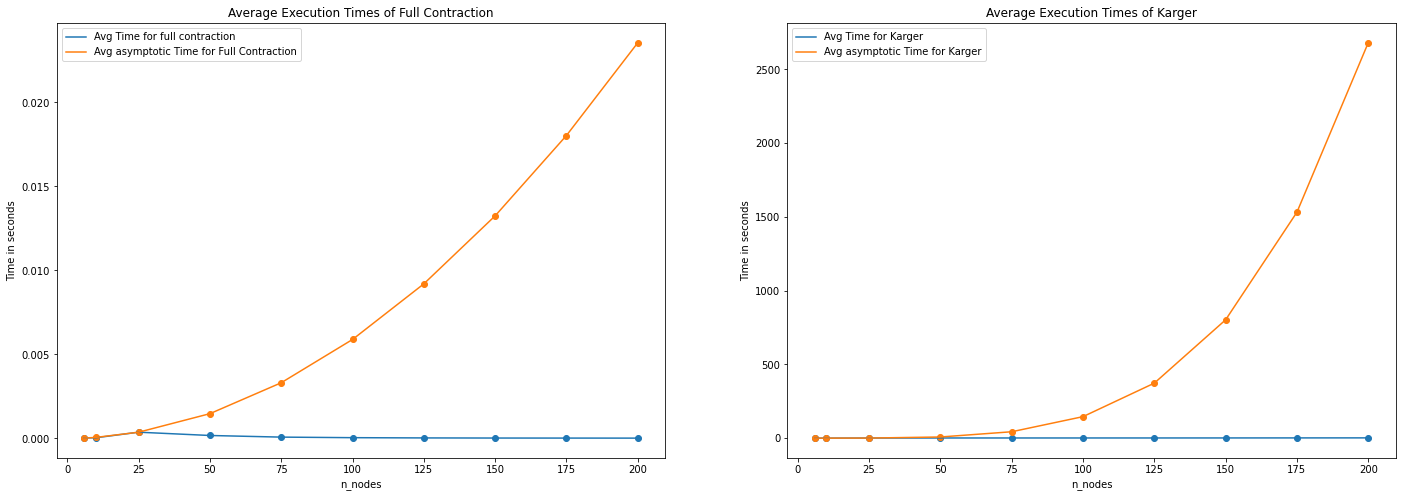

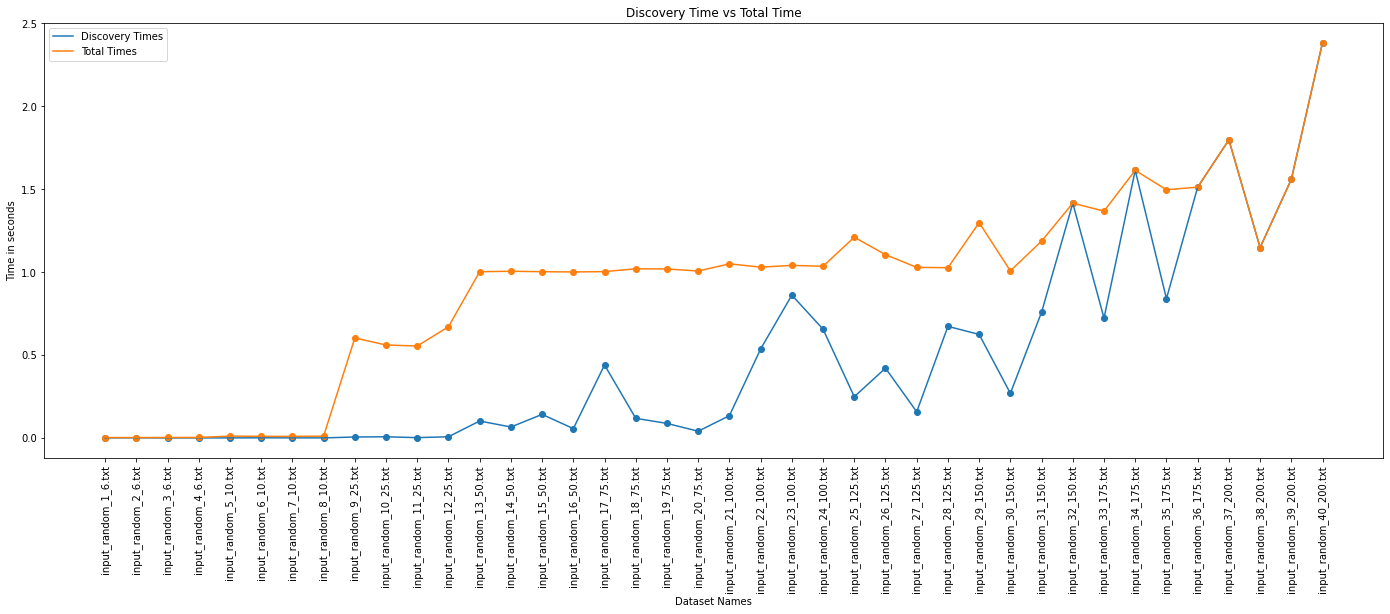

In [15]:
plot_results(results)

Like we said at the beginning of the notebook this results are not much interesting since we set a really low time_threshold, if you increase it to a reasonable value the results obtained should look much more interesting.

##PyPy plots

Like we said at the beginning we ran the algorithms that we described previously locally on a pc with a custom compiler called PyPy which is a lot faster and allowed us to terminate the algorithms before the end of the time threshold even on graph of high dimension.
When we ran the algorithms locally we set the time threshold to 300 seconds which is equivalent to five minutes.  
The results obtained where written on a result.txt file that we attached to the submission of the homework.  

Now we create the results data structure from such result.txt file.

In [16]:
results = []
with open(str(Path().absolute()) + "/" + "results.txt", 'r') as f:
    for item in f:
        e = item.split(",")
        results.append([e[0][2:-1], int(e[1]), int(e[2]), int(e[3]), int(e[4]), float(e[5]), float(e[6]), int(e[7]), float(e[8]), float(e[9]), float(e[10][:-2]) ])

By using the functions defined in the previous section we plot the table and the graph.  
The estimations were made on the time data calculated with the _PyPy_ compiler, so in the following graphs they probably won't be optimal. 

In [17]:
results=asymptotic_regularizer(results, 10**(-6.23), 10**(-6.5))

In [18]:
plot_table(results)

Dataset Name,Number of Nodes,Number of Iterations(K),Solution Found,Optimal Solution,Error(%),Discovery Time,Asymptotic Contraction Time,Avg Contraction Time,Asymptotic Karger Time,Total Time
input_random_1_6.txt,6,32,2,2,0.000000,0.000000,0.000021,0.000000,0.000734,0.000000
input_random_2_6.txt,6,32,1,1,0.000000,0.000000,0.000021,0.000000,0.000734,0.015643
input_random_3_6.txt,6,32,3,3,0.000000,0.000000,0.000021,0.000488,0.000734,0.015622
input_random_4_6.txt,6,32,4,4,0.000000,0.000000,0.000021,0.000000,0.000734,0.000000
input_random_5_10.txt,10,115,4,4,0.000000,0.015635,0.000059,0.000136,0.007281,0.031244
input_random_6_10.txt,10,115,3,3,0.000000,0.000000,0.000059,0.000272,0.007281,0.031242
input_random_7_10.txt,10,115,2,2,0.000000,0.000000,0.000059,0.000000,0.007281,0.000000
input_random_8_10.txt,10,115,1,1,0.000000,0.000000,0.000059,0.000136,0.007281,0.015620
input_random_9_25.txt,25,1005,7,7,0.000000,0.000000,0.000368,0.000062,0.397616,0.187462
input_random_10_25.txt,25,1005,6,6,0.000000,0.000000,0.000368,0.000031,0.397616,0.140594


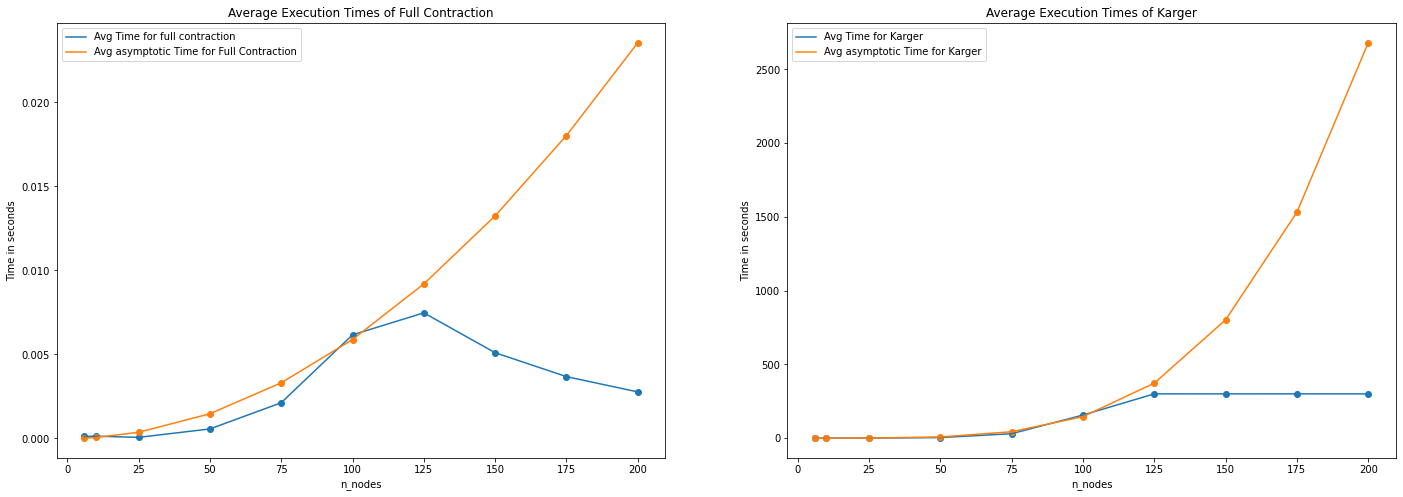

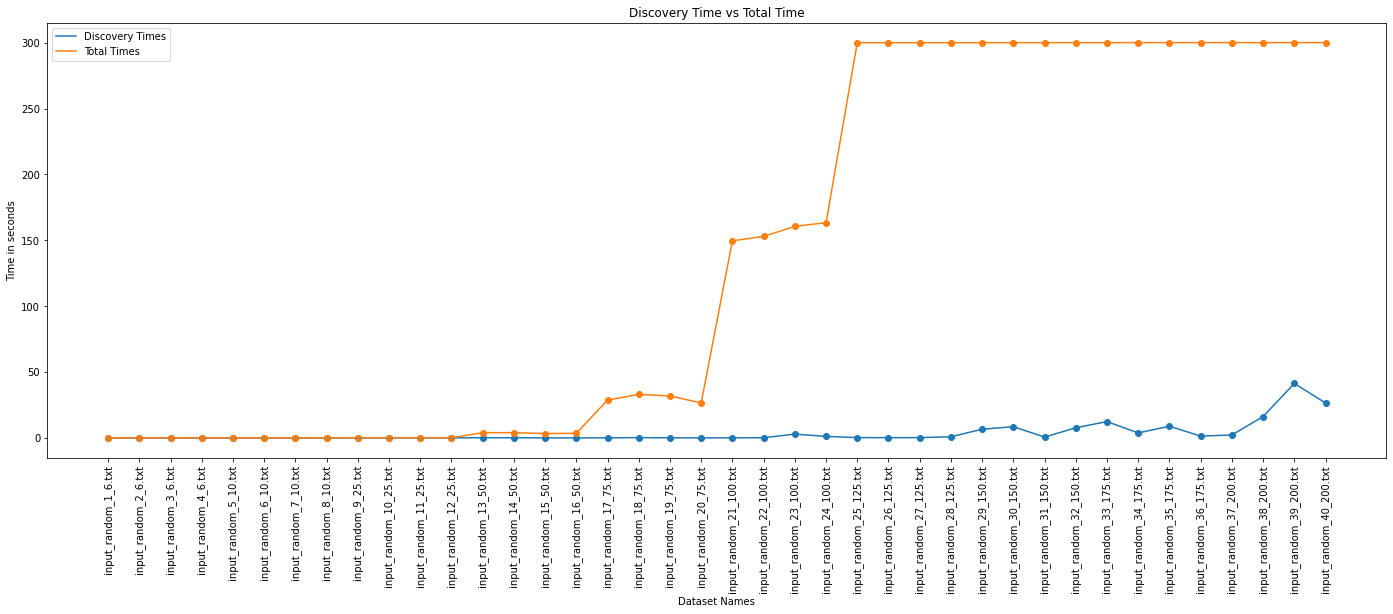

In [19]:
plot_results(results)

#Conclusions

We can clearly see from the first two graphs that the execution times seem to follow the asymptotic curves of $O(n^2)$ for the _full_contraction_ and of $O(n^4*log(n))$ for karger, at least until the execution times don't reach the time threshold of five minutes that we imposed.
  
Moreover we can also notice that in most of the cases the discovery_time is very very close to zero. Since we have the solutions to the problems we know that the algorithm always finds the best solution in a much lower time if compared to the overall execution time, even on the largest graphs where it can't even terminate the total number of iterations $k$. Thus we can deduce that to be sure to have a probability of $1-\frac{1}{n}$ of returning the best solution we have to run the full contraction $k=\frac{n^2}{2}*ln(n)$ times but in most of the cases, at least on the dataset we tested, the number of iterations that are really required to reach the optimal solution is way way lower.

# Credits

This notebook was realized by:
* **Giacomo Barzon**  (1236597)
* **Diego Mazzalovo** (1236592)
* **Giacomo Greggio** (1234236)